In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Деревья классификации
--------------------------------------

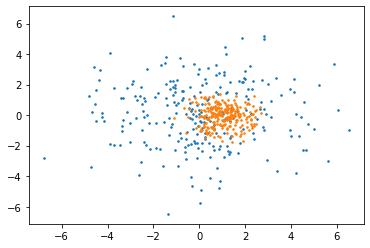

In [2]:
np.random.seed(43)

n = 250

mu1 = np.array([0.0,0])
mu2 = np.array([1.0,0])
sigma1 = 5.0 * np.diag(np.array([1.0, 1.0]))
sigma2 = 0.5 * np.diag(np.array([1.0, 1.0]))

x1 = np.random.multivariate_normal(mu1, sigma1, n)
x2 = np.random.multivariate_normal(mu2, sigma2, n)
x = np.vstack([x1, x2])
y = np.concatenate([np.full(x1.shape[0], 0), np.full(x2.shape[0], 1)])

plt.figure()
plt.scatter(*x1.T,s=2.5)
plt.scatter(*x2.T,s=2.5)

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [4]:
def flat_dict(x):
    if len(x) == 0:
        return dict()
    return {k: np.asarray([e[k] for e in x]) for k in x[0].keys()}

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

max_depths = np.arange(1, 2 * np.log2(n))

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for max_depth in max_depths:
    c = DecisionTreeClassifier(max_depth=max_depth)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

In [6]:
scores = flat_dict(scores)

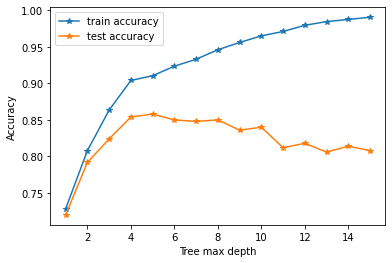

In [7]:
plt.plot(max_depths, scores['train_accuracy'].mean(axis=1), '-*', label="train accuracy")
plt.plot(max_depths, scores['test_accuracy'].mean(axis=1), '-*', label="test accuracy")
plt.xlabel("Tree max depth")
plt.ylabel("Accuracy")
_ = plt.legend()

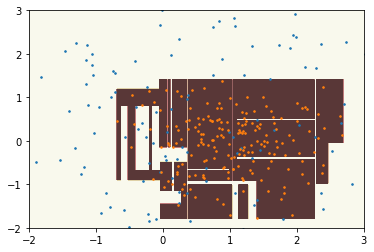

In [8]:
x_grid = np.linspace(np.min(x), np.max(x), 2000)
xx, yy = np.meshgrid(x_grid, x_grid)
xx_test = np.stack((xx,yy), axis=-1).reshape(-1, 2)

c = DecisionTreeClassifier(random_state=0, max_depth=15)

c.fit(x_train, y_train)
pred = c.predict(xx_test).reshape(xx.shape)

x1_train = x_train[y_train == 0]
x2_train = x_train[y_train == 1]

plt.figure()
plt.xlim(-2,3)
plt.ylim(-2,3)
plt.contourf(xx, yy, pred, cmap="pink_r")
plt.scatter(*x1_train.T,s=2.5)
plt.scatter(*x2_train.T,s=2.5)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

min_samples_leafs = np.arange(1, 20)

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for min_samples_leaf in min_samples_leafs:
    c = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

In [10]:
scores = flat_dict(scores)

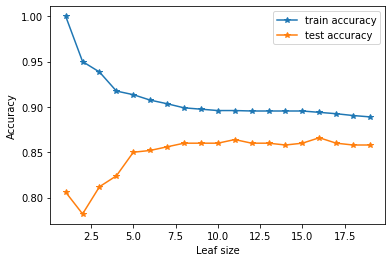

In [11]:
plt.plot(min_samples_leafs, scores['train_accuracy'].mean(axis=1), '-*', label="train accuracy")
plt.plot(min_samples_leafs, scores['test_accuracy'].mean(axis=1), '-*', label="test accuracy")
plt.xlabel("Leaf size")
plt.ylabel("Accuracy")
_ = plt.legend()

In [12]:
c = DecisionTreeClassifier(random_state=0)

path = c.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

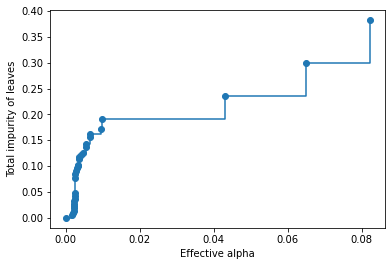

In [13]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
_ = ax.set_ylabel("Total impurity of leaves")

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for ccp_alpha in ccp_alphas:
    c = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

In [15]:
scores = flat_dict(scores)

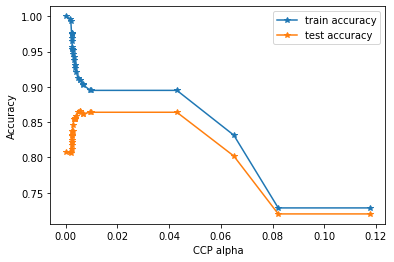

In [16]:
plt.plot(ccp_alphas, scores['train_accuracy'].mean(axis=1), '-*', label="train accuracy")
plt.plot(ccp_alphas, scores['test_accuracy'].mean(axis=1), '-*', label="test accuracy")
plt.xlabel("CCP alpha")
plt.ylabel("Accuracy")
_ = plt.legend()

Деревья классификации своими руками
-----------------------------------------------------

In [17]:
from collections import namedtuple
from scipy import optimize

Leaf = namedtuple('Leaf', ('value', 'x', 'y'))
Node = namedtuple('Node', ('feature', 'value', 'impurity', 'left', 'right',))

class BaseDecisionTree:
    def __init__(self, x, y, max_depth=np.inf):
        self.x = np.atleast_2d(x)
        self.y = np.atleast_1d(y)
        self.max_depth = max_depth
        
        self.features = x.shape[1]
        
        self.root = self.build_tree(self.x, self.y)
    
    # Will fail in case of depth ~ 1000 because of limit of recursion calls
    def build_tree(self, x, y, depth=1):
        if depth > self.max_depth or self.criteria(y) < 1e-6:
            return Leaf(self.leaf_value(y), x, y)
        
        feature, value, impurity = self.find_best_split(x, y)
        
        left_xy, right_xy = self.partition(x, y, feature, value)
        left = self.build_tree(*left_xy, depth=depth + 1)
        right = self.build_tree(*right_xy, depth=depth + 1)
        
        return Node(feature, value, impurity, left, right)
    
    def leaf_value(self, y):
        raise NotImplementedError
    
    def partition(self, x, y, feature, value):
        i = x[:, feature] >= value
        j = np.logical_not(i)
        return (x[j], y[j]), (x[i], y[i])
    
    def _impurity_partition(self, value, feature, x, y):
        (_, left), (_, right) = self.partition(x, y, feature, value)
        return self.impurity(left, right)
    
    def find_best_split(self, x, y):
        best_feature, best_value, best_impurity = 0, x[0,0], np.inf
        for feature in range(self.features):
            if x.shape[0] > 2:
                x_interval = np.sort(x[:,feature])
                res = optimize.minimize_scalar(
                    self._impurity_partition, 
                    args=(feature, x, y),
                    bounds=(x_interval[1], x_interval[-1]),
                    method='Bounded',
                )
                assert res.success
                value = res.x
                impurity = res.fun
            else:
                value = np.max(x[:,feature])
                impurity = self._impurity_partition(value, feature, x, y)
            if impurity < best_impurity:
                best_feature, best_value, best_impurity = feature, value, impurity
        return best_feature, best_value, best_impurity
    
    # Can be optimized for given .criteria()
    def impurity(self, left, right):
        h_l = self.criteria(left)
        h_r = self.criteria(right)
        return (left.size * h_l + right.size * h_r) / (left.size + right.size)
    
    def criteria(self, y):
        raise NotImplementedError
        
    def predict(self, x):
        x = np.atleast_2d(x)
        y = np.empty(x.shape[0], dtype=self.y.dtype)
        for i, row in enumerate(x):
            node = self.root
            while not isinstance(node, Leaf):
                if row[node.feature] >= node.value:
                    node = node.right
                else:
                    node = node.left
            y[i] = node.value
        return y

In [18]:
class MyDecisionTreeClassifier(BaseDecisionTree):
    def __init__(self, x, y, *args, random_state=None, **kwargs):
        y = np.asarray(y, dtype=int)
        self.random_state = np.random.RandomState(random_state)
        self.classes = np.unique(y)
        super().__init__(x, y, *args, **kwargs)
        
    def leaf_value(self, y):
        class_counts = np.sum(y == self.classes.reshape(-1,1), axis=1)
        m = np.max(class_counts)
        most_common = self.classes[class_counts == m]
        if most_common.size == 1:
            return most_common[0]
        return self.random_state.choice(most_common)
    
    def criteria(self, y):
        """Gini"""
        p = np.sum(y == self.classes.reshape(-1,1), axis=1) / y.size
        return np.sum(p * (1 - p))

In [19]:
c = MyDecisionTreeClassifier(x_train, y_train, max_depth=5, random_state=0)
pred = c.predict(xx_test).reshape(xx.shape)

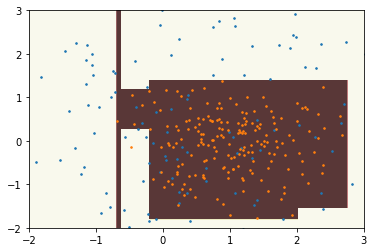

In [20]:
x1_train = x_train[y_train == 0]
x2_train = x_train[y_train == 1]

plt.figure()
plt.xlim(-2,3)
plt.ylim(-2,3)
plt.contourf(xx, yy, pred, cmap="pink_r")
plt.scatter(*x1_train.T,s=2.5)
plt.scatter(*x2_train.T,s=2.5)

**Задание 6.1** Перед вами класс `BaseDecisionTree`. Используйте класс `MyDecisionTreeClassifier` в качестве примера, чтобы самостоятельно сделать простое дерево регрессии `MyDecisionTreeRegressor`.

Для задачи регрессии в качестве значения листа уместно взять среднее арифметическое значений всех точек содержащихся в узле, в качестве критерия - среднеквадратичное отклонение.

Используя синтетический пример с зависимостью (приведен ниже)
$$y = 2 x + 1 + \epsilon$$
удебитесь в работоспособности дерева регрессии, подберите наилучший параметр `max_depth`.

*Бонусные баллы* можно получить если реализовать функцию `impurity` более эффективно, упростив формулы для случая регрессии.

In [24]:
class MyDecisionTreeRegressor(BaseDecisionTree):
    def __init__(self, x, y, *args, random_state=None, **kwargs):
        y = np.asarray(y )
        self.random_state = np.random.RandomState(random_state)
        super().__init__(x, y, *args, **kwargs)
        
    def leaf_value(self, y):
        return np.mean(y)
    
    def criteria(self, y):
        """среднеквадратичное отклонение"""
        return np.std(y)


train score = 0.0000
test score = 0.0190


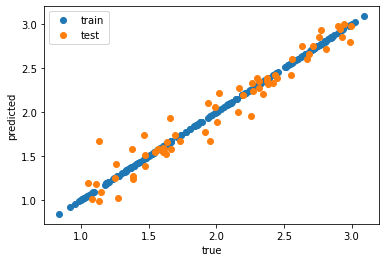

In [25]:
from sklearn.metrics import mean_squared_error

np.random.seed(42)

n = 250
x = np.random.uniform(0, 1, size=(n, 1))
y = 2 * x[:, 0] + 1
y = y + np.random.normal(0, 0.1, size=y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

dtr = MyDecisionTreeRegressor(x_train, y_train, random_state=0)

plt.xlabel('true')
plt.ylabel('predicted')
plt.plot(y_train, dtr.predict(x_train), 'o', label='train')
plt.plot(y_test, dtr.predict(x_test), 'o', label='test')
plt.legend()

train_score = mean_squared_error(y_train, dtr.predict(x_train))
test_score = mean_squared_error(y_test, dtr.predict(x_test))

print("train score = {:.4f}".format(train_score))
print("test score = {:.4f}".format(test_score))

**Задание 6.2**

Воспроизведите регрессию из Задания 6.1 используя реализацию дерева регрессии `sklearn.tree.DecisionTreeRegressor`. Сравните полученные результаты.